In [1]:
import numpy as np
import random
import datetime
from dataclasses import dataclass
from typing import List, Dict, Tuple, Sequence, Callable

In [2]:
import networkx as nx

In [3]:
from networkx import Graph

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

In [5]:
import json
import urllib.request


In [6]:
from shapely.geometry import shape, MultiPolygon, LineString, MultiLineString

## GEO files for US map and colors

In [7]:
GEOJSON_COUNTIES ='http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_050_00_20m.json'
GEOJSON_STATES = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_20m.json'



## A dataclass to represent a Map of states

In [8]:
@dataclass
class Map:
    states  : Dict
    G       : Graph


## Functions to manipulate GEO maps

In [23]:
def load_data(file):
    url = GEOJSON_STATES if file == 'states' else GEOJSON_COUNTIES
    url = urllib.request.urlopen(url)
    data = json.loads(url.read().decode(encoding = "ISO-8859-1"))
    return data


def load_map_data(map_name):
    if map_name == 'States':
        data = load_data('states')
    else:
        data = load_data('counties')
        data = get_county(data, map_name)
    return data

def get_county(data, target_state):
    county_feats = []
    feats = data['features']
    for feat in feats:
        state = feat['properties']['STATE']
        if STATES_CODE[state] == target_state:
            county_feats.append(feat)
    if county_feats:
        data['features'] = county_feats
        return data
    raise NameError('State {} does not exist'.format(target_state))

def adjacency_test(county1, county2):
    return not county1.intersection(county2).is_empty


def list_json(data):
    features = data['features']
    nb_counties = len(features)
    print(nb_counties)
    
    for idx in range(nb_counties):
        county_name = features[idx]['properties']['NAME']
        print(county_name)
        geom = features[idx]['geometry']
        county_geo = shape(geom)
        print(county_geo.geom_type)
        mpl_poly = Polygon(np.array(county_geo.exterior), facecolor=facecolor, linewidth=5.0, alpha=0.5, edgecolor='black')
        print(mpl_poly)
        
def build_map(data):
    features = data['features']
    nb_counties = len(features)
    idx_name_map = {}
    mat = []
    for idx in range(nb_counties):
        county_name = features[idx]['properties']['NAME']
        idx_name_map[idx] = county_name
        county_geo = shape(features[idx]['geometry'])
        lst = []
        for other_idx in range(nb_counties):
            other_name = features[other_idx]['properties']['NAME']
            other_geo = shape(features[other_idx]['geometry'])
            if adjacency_test(county_geo, other_geo) and county_name != other_name:
                lst.append(1)
            else:
                lst.append(0)
        mat.append(lst)
    return idx_name_map, np.array(mat)


def color_map(data, usmap):
    features = data['features']
    dt = usmap.G.nodes.data()
    for i, feat in enumerate(features):
        cdict = dt[i]
        feat['properties']['color'] = cdict['color']
        
    return data

def plot_map(data, map_title,figsize=(8, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    features = data['features']
    shapes = [shape(feat['geometry']) for feat in data['features']]
    properties = [feat['properties'] for feat in data['features']]
    polygons = MultiPolygon(shapes)
    for prop, polygon in zip(properties, polygons):
        facecolor = prop['color'] if 'color' in prop else 'gray'
        mpl_poly = Polygon(np.array(polygon.exterior), facecolor=facecolor, linewidth=5.0, alpha=0.5, edgecolor='black')
        ax.add_patch(mpl_poly)
    ax.relim()
    ax.autoscale()
    ax.axis('off')
    ax.set_title(map_title)
    #return fig

def save_to_file(fig, fname):
    fig.savefig(fname)



## Functions to manipulate US maps

In [10]:
def state_edges(state_code, usmap):
    name = usmap.states[state_code]
    link = int(state_code)
    edges = G.edges([link])
    neig = []
    ineig = []
    for e in edges:
        neig.append(usmap.states[e[1]])
        ineig.append(e[1])
    return name, ineig, neig

In [11]:
def add_colors_to_usmap(colors, usmap):
    G = usmap.G
    st = usmap.states
    for i in range(len(G.nodes)):
        G.nodes[i]['color'] = COLORS[colors[i]]
    #print(G.nodes.data())
    
    return Map(st,G)

## Genetic code

In [12]:
def generate_parent_genes(length: int, geneSet: Sequence)->List:
    genes = []
    while len(genes) < length:
        sampleSize = min(length - len(genes), len(geneSet))
        genes.extend(random.sample(geneSet, sampleSize))
    return genes

def mutate_genes(genes: List, geneSet: List)->List:
    """Mutate genes target choosing character from geneSet"""

    mutatedGenes         = genes[:]
    index                = random.randrange(0, len(mutatedGenes))
    newGene, alternate   = random.sample(geneSet, 2)
    mutatedGenes[index]  = alternate if newGene == mutatedGenes[index] else newGene
    return mutatedGenes

def get_fitness(genes, usMap):
    ft = 0
    for i in range(len(G.nodes)):
        pft = 0
        name, ineig, neig = state_edges(i, usMap)
        print(name, G.nodes[i]['color'], neig, ineig)
        for j in ineig:
            if G.nodes[i]['color'] != G.nodes[j]['color']:
                pft+=1
            if i < 9:
                print(j, G.nodes[j]['color'])
        print(pft)
        ft +=pft 
    return ft
 
def fitness(genes, usMap):
    ft = 0
    for i in range(len(G.nodes)):
        _, ineig, _ = state_edges(i, usMap)
        for j in ineig:
            if G.nodes[i]['color'] != G.nodes[j]['color']:
                ft+=1
             
    return ft


def optimize(usMap, geneSet,get_fitness, optimalFitness,
             verbose=True, imax=10000):

    random.seed()
    startTime = datetime.datetime.now()
    guess = generate_parent_genes(len(usMap.G), geneSet)
    usm   = add_colors_to_usmap(guess, usMap)
    
    print(f'First guess = {guess}')

    i = 0
    f = fitness(guess, usm)
   
    while f < optimalFitness and i < imax:
        newGuess = mutate_genes(guess, geneSet)
        usm = add_colors_to_usmap(newGuess, usm)
        fn = fitness(newGuess, usm)
        time = datetime.datetime.now() - startTime
        if fn >= f:
            if verbose and fn > f:
                print(f'new guess increased fitness: {newGuess}, fitness = {fn} i = {i}, time = {time}')
            guess = newGuess
            f = fn

        i+=1
    return i, time, usm

## NB

## Define genset

In [13]:
geneset = range(5) # five colors

COLORS = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'yellow',
    4: 'orange',
}


### Load and plot the map of the United States 

In [15]:
data = load_map_data(map_name='States')

In [21]:
list_json(data)

52
Arizona
Polygon
Arkansas
Polygon
California
MultiPolygon
Colorado
Polygon
Connecticut
Polygon
District of Columbia
Polygon
Georgia
Polygon
Hawaii
MultiPolygon
Illinois
Polygon
Indiana
Polygon
Louisiana
MultiPolygon
Minnesota
Polygon
Mississippi
MultiPolygon
Montana
Polygon
New Mexico
Polygon
North Dakota
Polygon
Oklahoma
Polygon
Pennsylvania
Polygon
Tennessee
Polygon
Virginia
MultiPolygon
Puerto Rico
MultiPolygon
Delaware
MultiPolygon
West Virginia
Polygon
Wisconsin
MultiPolygon
Wyoming
Polygon
Alabama
MultiPolygon
Alaska
MultiPolygon
Florida
MultiPolygon
Idaho
Polygon
Kansas
Polygon
Maryland
MultiPolygon
New Jersey
Polygon
North Carolina
MultiPolygon
South Carolina
Polygon
Washington
MultiPolygon
Vermont
Polygon
Utah
Polygon
Iowa
Polygon
Kentucky
MultiPolygon
Maine
MultiPolygon
Massachusetts
MultiPolygon
Michigan
MultiPolygon
Missouri
Polygon
Nebraska
Polygon
Nevada
Polygon
New Hampshire
Polygon
New York
MultiPolygon
Ohio
MultiPolygon
Oregon
Polygon
Rhode Island
MultiPolygon
South 

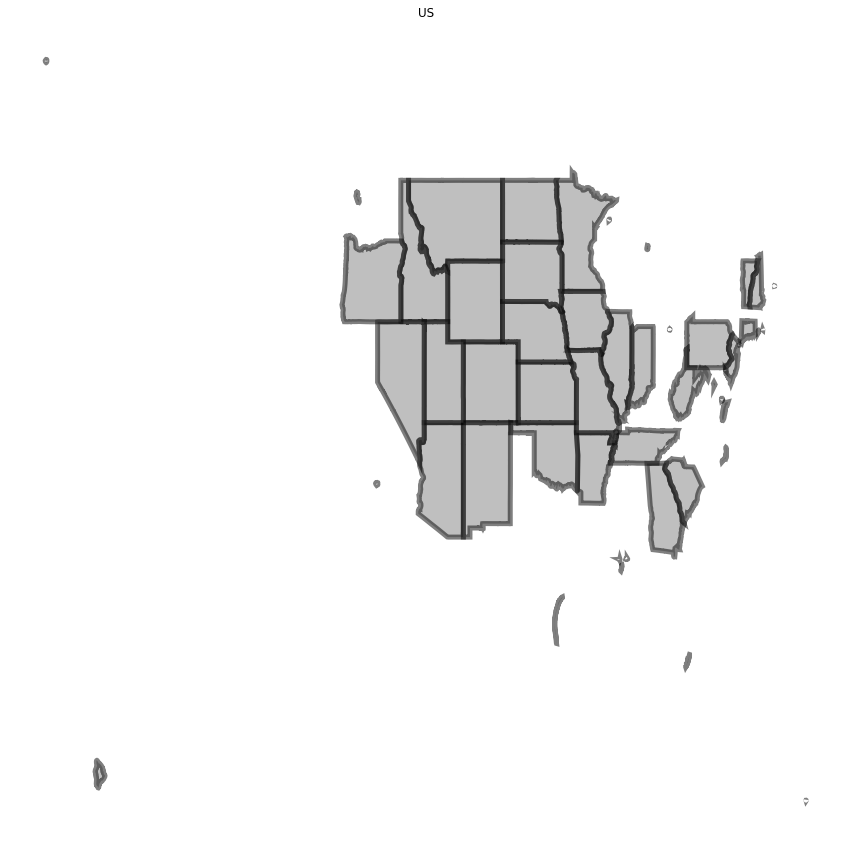

In [22]:
plot_map(data, 'US', (15,15))

## state map (a dict order by index) and adjacency matrix

In [52]:
state_map, admat = build_map(data)

In [53]:
state_map

{0: 'Arizona',
 1: 'Arkansas',
 2: 'California',
 3: 'Colorado',
 4: 'Connecticut',
 5: 'District of Columbia',
 6: 'Georgia',
 7: 'Hawaii',
 8: 'Illinois',
 9: 'Indiana',
 10: 'Louisiana',
 11: 'Minnesota',
 12: 'Mississippi',
 13: 'Montana',
 14: 'New Mexico',
 15: 'North Dakota',
 16: 'Oklahoma',
 17: 'Pennsylvania',
 18: 'Tennessee',
 19: 'Virginia',
 20: 'Puerto Rico',
 21: 'Delaware',
 22: 'West Virginia',
 23: 'Wisconsin',
 24: 'Wyoming',
 25: 'Alabama',
 26: 'Alaska',
 27: 'Florida',
 28: 'Idaho',
 29: 'Kansas',
 30: 'Maryland',
 31: 'New Jersey',
 32: 'North Carolina',
 33: 'South Carolina',
 34: 'Washington',
 35: 'Vermont',
 36: 'Utah',
 37: 'Iowa',
 38: 'Kentucky',
 39: 'Maine',
 40: 'Massachusetts',
 41: 'Michigan',
 42: 'Missouri',
 43: 'Nebraska',
 44: 'Nevada',
 45: 'New Hampshire',
 46: 'New York',
 47: 'Ohio',
 48: 'Oregon',
 49: 'Rhode Island',
 50: 'South Dakota',
 51: 'Texas'}

In [54]:
admat

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

## Create a graph from the AMAT

In [55]:
G = nx.Graph(admat)

In [56]:
G

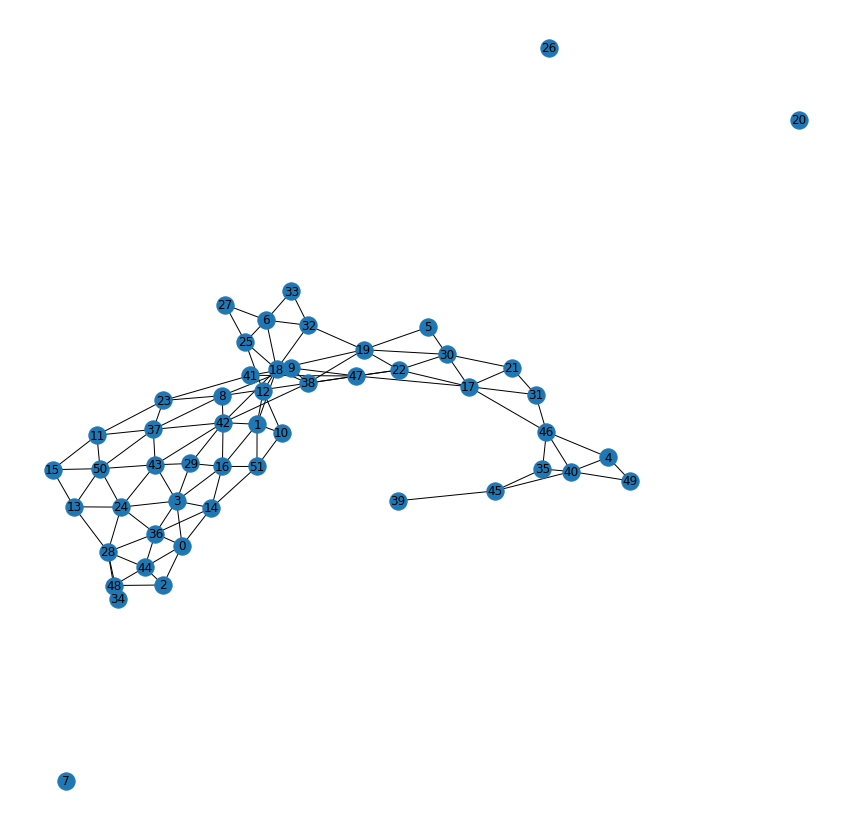

In [57]:
fig, ax = plt.subplots(figsize=(15,15))
nx.draw(G, with_labels=True)

## Collect info into a US map dataclass

In [58]:
usmap = Map(state_map,G)

In [84]:
usmap

Map(states={0: 'Arizona', 1: 'Arkansas', 2: 'California', 3: 'Colorado', 4: 'Connecticut', 5: 'District of Columbia', 6: 'Georgia', 7: 'Hawaii', 8: 'Illinois', 9: 'Indiana', 10: 'Louisiana', 11: 'Minnesota', 12: 'Mississippi', 13: 'Montana', 14: 'New Mexico', 15: 'North Dakota', 16: 'Oklahoma', 17: 'Pennsylvania', 18: 'Tennessee', 19: 'Virginia', 20: 'Puerto Rico', 21: 'Delaware', 22: 'West Virginia', 23: 'Wisconsin', 24: 'Wyoming', 25: 'Alabama', 26: 'Alaska', 27: 'Florida', 28: 'Idaho', 29: 'Kansas', 30: 'Maryland', 31: 'New Jersey', 32: 'North Carolina', 33: 'South Carolina', 34: 'Washington', 35: 'Vermont', 36: 'Utah', 37: 'Iowa', 38: 'Kentucky', 39: 'Maine', 40: 'Massachusetts', 41: 'Michigan', 42: 'Missouri', 43: 'Nebraska', 44: 'Nevada', 45: 'New Hampshire', 46: 'New York', 47: 'Ohio', 48: 'Oregon', 49: 'Rhode Island', 50: 'South Dakota', 51: 'Texas'}, G=<networkx.classes.graph.Graph object at 0x7fbd28cc1090>)

In [60]:
usmap.states[1]

'Arkansas'

In [61]:
name, ineig, neig = state_edges(1, usmap)
print(f' state name = {name}, neighbours index = {ineig} neighbours names = {neig}')

 state name = Arkansas, neighbours index = [10, 12, 16, 18, 42, 51] neighbours names = ['Louisiana', 'Mississippi', 'Oklahoma', 'Tennessee', 'Missouri', 'Texas']


In [62]:
name, ineig, neig = state_edges(7, usmap)
print(f' state name = {name}, neighbours index = {ineig} neighbours names = {neig}')

 state name = Hawaii, neighbours index = [] neighbours names = []


In [63]:
name, ineig, neig = state_edges(20, usmap)
print(f' state name = {name}, neighbours index = {ineig} neighbours names = {neig}')

 state name = Puerto Rico, neighbours index = [] neighbours names = []


In [64]:
name, ineig, neig = state_edges(26, usmap)
print(f' state name = {name}, neighbours index = {ineig} neighbours names = {neig}')

 state name = Alaska, neighbours index = [] neighbours names = []


In [65]:
usmap.G.edges([20])

EdgeDataView([])

In [66]:
usmap.G.edges([0])

EdgeDataView([(0, 2), (0, 3), (0, 14), (0, 36), (0, 44)])

In [67]:
usmap.G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51))

In [31]:
len(G.nodes)

52

## Generate genes

In [94]:
genes = generate_parent_genes(len(usmap.G), geneset)
print(len(genes), genes)

52 [3, 0, 4, 2, 1, 0, 1, 2, 3, 4, 4, 3, 2, 1, 0, 2, 4, 3, 0, 1, 0, 2, 4, 3, 1, 2, 1, 0, 4, 3, 4, 1, 3, 0, 2, 2, 1, 0, 4, 3, 0, 1, 2, 3, 4, 0, 1, 4, 2, 3, 1, 2]


## Add colors according to these genes

In [95]:
usm = add_colors_to_usmap(genes, usmap)

In [96]:
usm

Map(states={0: 'Arizona', 1: 'Arkansas', 2: 'California', 3: 'Colorado', 4: 'Connecticut', 5: 'District of Columbia', 6: 'Georgia', 7: 'Hawaii', 8: 'Illinois', 9: 'Indiana', 10: 'Louisiana', 11: 'Minnesota', 12: 'Mississippi', 13: 'Montana', 14: 'New Mexico', 15: 'North Dakota', 16: 'Oklahoma', 17: 'Pennsylvania', 18: 'Tennessee', 19: 'Virginia', 20: 'Puerto Rico', 21: 'Delaware', 22: 'West Virginia', 23: 'Wisconsin', 24: 'Wyoming', 25: 'Alabama', 26: 'Alaska', 27: 'Florida', 28: 'Idaho', 29: 'Kansas', 30: 'Maryland', 31: 'New Jersey', 32: 'North Carolina', 33: 'South Carolina', 34: 'Washington', 35: 'Vermont', 36: 'Utah', 37: 'Iowa', 38: 'Kentucky', 39: 'Maine', 40: 'Massachusetts', 41: 'Michigan', 42: 'Missouri', 43: 'Nebraska', 44: 'Nevada', 45: 'New Hampshire', 46: 'New York', 47: 'Ohio', 48: 'Oregon', 49: 'Rhode Island', 50: 'South Dakota', 51: 'Texas'}, G=<networkx.classes.graph.Graph object at 0x7fbd28cc1090>)

In [97]:
usm.G.nodes[0]

{'color': 'yellow'}

In [98]:
usm

Map(states={0: 'Arizona', 1: 'Arkansas', 2: 'California', 3: 'Colorado', 4: 'Connecticut', 5: 'District of Columbia', 6: 'Georgia', 7: 'Hawaii', 8: 'Illinois', 9: 'Indiana', 10: 'Louisiana', 11: 'Minnesota', 12: 'Mississippi', 13: 'Montana', 14: 'New Mexico', 15: 'North Dakota', 16: 'Oklahoma', 17: 'Pennsylvania', 18: 'Tennessee', 19: 'Virginia', 20: 'Puerto Rico', 21: 'Delaware', 22: 'West Virginia', 23: 'Wisconsin', 24: 'Wyoming', 25: 'Alabama', 26: 'Alaska', 27: 'Florida', 28: 'Idaho', 29: 'Kansas', 30: 'Maryland', 31: 'New Jersey', 32: 'North Carolina', 33: 'South Carolina', 34: 'Washington', 35: 'Vermont', 36: 'Utah', 37: 'Iowa', 38: 'Kentucky', 39: 'Maine', 40: 'Massachusetts', 41: 'Michigan', 42: 'Missouri', 43: 'Nebraska', 44: 'Nevada', 45: 'New Hampshire', 46: 'New York', 47: 'Ohio', 48: 'Oregon', 49: 'Rhode Island', 50: 'South Dakota', 51: 'Texas'}, G=<networkx.classes.graph.Graph object at 0x7fbd28cc1090>)

## Create a color map and draw it

In [99]:
dc = color_map(data, usm)

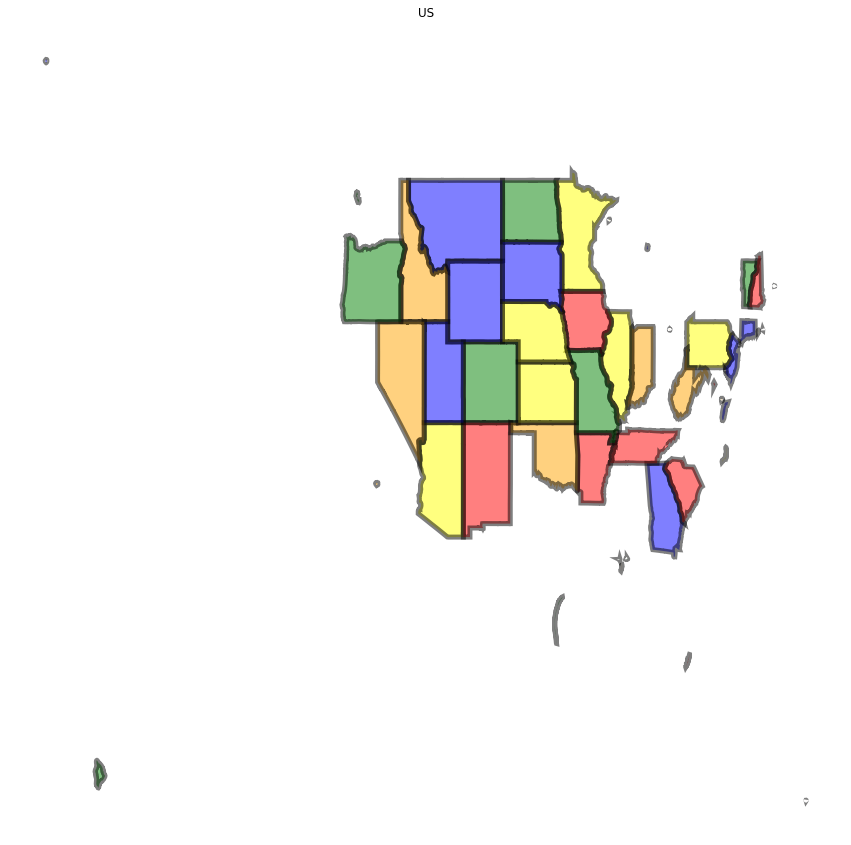

In [100]:
plot_map(dc, 'US', (15,15))

In [101]:
get_fitness(genes, usm)

Arizona yellow ['California', 'Colorado', 'New Mexico', 'Utah', 'Nevada'] [2, 3, 14, 36, 44]
2 orange
3 green
14 red
36 blue
44 orange
5
Arkansas red ['Louisiana', 'Mississippi', 'Oklahoma', 'Tennessee', 'Missouri', 'Texas'] [10, 12, 16, 18, 42, 51]
10 orange
12 green
16 orange
18 red
42 green
51 green
5
California orange ['Arizona', 'Nevada', 'Oregon'] [0, 44, 48]
0 yellow
44 orange
48 green
2
Colorado green ['Arizona', 'New Mexico', 'Oklahoma', 'Wyoming', 'Kansas', 'Utah', 'Nebraska'] [0, 14, 16, 24, 29, 36, 43]
0 yellow
14 red
16 orange
24 blue
29 yellow
36 blue
43 yellow
7
Connecticut blue ['Massachusetts', 'New York', 'Rhode Island'] [40, 46, 49]
40 red
46 blue
49 yellow
2
District of Columbia red ['Virginia', 'Maryland'] [19, 30]
19 blue
30 orange
2
Georgia blue ['Tennessee', 'Alabama', 'Florida', 'North Carolina', 'South Carolina'] [18, 25, 27, 32, 33]
18 red
25 green
27 red
32 yellow
33 red
5
Hawaii green [] []
0
Illinois yellow ['Indiana', 'Wisconsin', 'Iowa', 'Kentucky', 'Mis

176

## Optimal fitness

In [102]:
optimalFitness = 2 * len(usm.G.edges)
optimalFitness

218

In [103]:
fitness(genes, usm)

176

In [104]:
i, time, usm = optimize(usm, geneset, fitness, optimalFitness, verbose=True, imax=10000)

First guess = [1, 0, 2, 4, 3, 1, 3, 4, 0, 2, 3, 4, 2, 1, 0, 4, 3, 2, 0, 1, 2, 1, 4, 0, 3, 4, 2, 3, 1, 0, 0, 1, 4, 3, 2, 0, 4, 2, 3, 1, 4, 2, 3, 0, 1, 2, 1, 3, 4, 0, 3, 2]
new guess increased fitness: [1, 0, 2, 4, 3, 4, 3, 4, 0, 2, 3, 4, 2, 1, 0, 4, 3, 2, 0, 1, 4, 1, 4, 0, 3, 4, 2, 3, 1, 0, 0, 1, 4, 3, 2, 0, 4, 2, 3, 1, 4, 2, 3, 0, 1, 2, 1, 3, 4, 0, 3, 2], fitness = 184 i = 3, time = 0:00:00.004941
new guess increased fitness: [1, 0, 2, 4, 3, 4, 3, 4, 0, 2, 3, 4, 2, 1, 0, 4, 3, 2, 0, 1, 4, 1, 4, 0, 3, 4, 2, 3, 1, 0, 0, 3, 4, 3, 2, 0, 4, 2, 3, 1, 4, 2, 3, 0, 1, 2, 1, 3, 4, 0, 3, 2], fitness = 188 i = 4, time = 0:00:00.006041
new guess increased fitness: [1, 0, 2, 4, 3, 4, 3, 4, 0, 2, 3, 4, 2, 1, 0, 4, 3, 2, 0, 1, 4, 1, 4, 0, 3, 4, 2, 3, 1, 0, 0, 3, 4, 3, 2, 0, 4, 2, 3, 1, 4, 2, 1, 0, 1, 2, 1, 3, 4, 0, 3, 2], fitness = 192 i = 8, time = 0:00:00.009575
new guess increased fitness: [1, 0, 2, 4, 3, 4, 3, 4, 0, 2, 3, 4, 2, 1, 0, 4, 3, 2, 0, 1, 4, 1, 4, 0, 0, 4, 2, 3, 1, 0, 0, 3, 4, 3, 2, 0, 4

In [105]:
dc = color_map(data, usm)

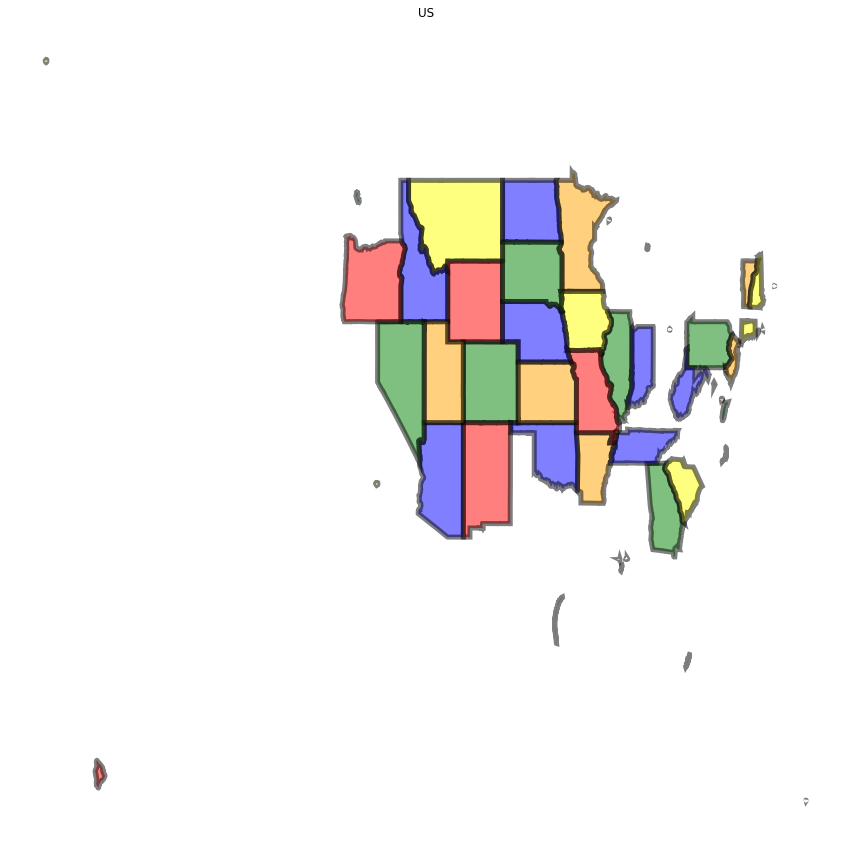

In [106]:
plot_map(dc, 'US', (15,15))